# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


## Preparation

In [102]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

display(data.head(5))


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [103]:
data.dtypes

num_orders    int64
dtype: object

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Analysis

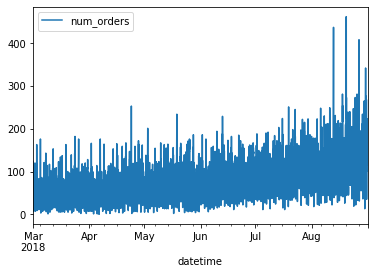

In [105]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.plot()
plt.show()

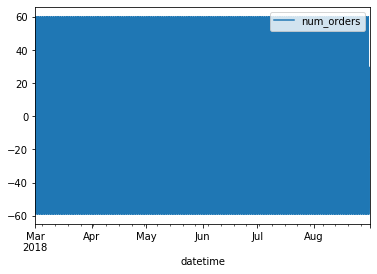

In [106]:
decomposed = seasonal_decompose(data)
decomposed.seasonal.plot()
plt.show()

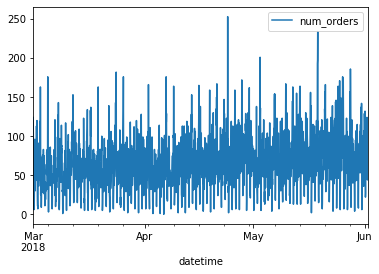

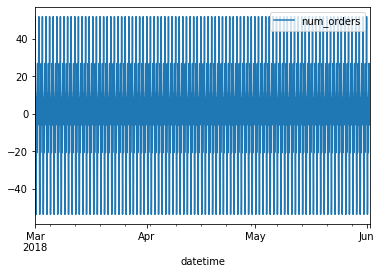

In [107]:
data.sort_index(inplace=True)
data_1 = data['2018-03-01':'2018-06-01']
data_1 = data_1.resample('1H').sum()
data_1.plot()
decomposed = seasonal_decompose(data_1)
decomposed.seasonal.plot()
plt.show()

The purpose of slicing May to June is to see the behaviour of data more clearly.

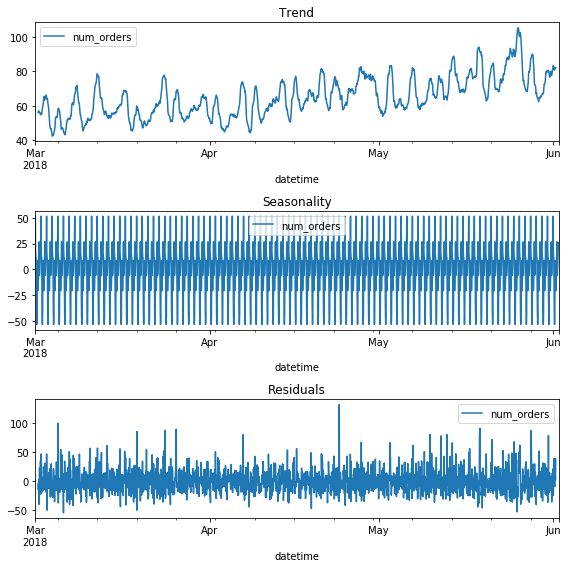

In [108]:
decomposed = seasonal_decompose(data_1)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout() 


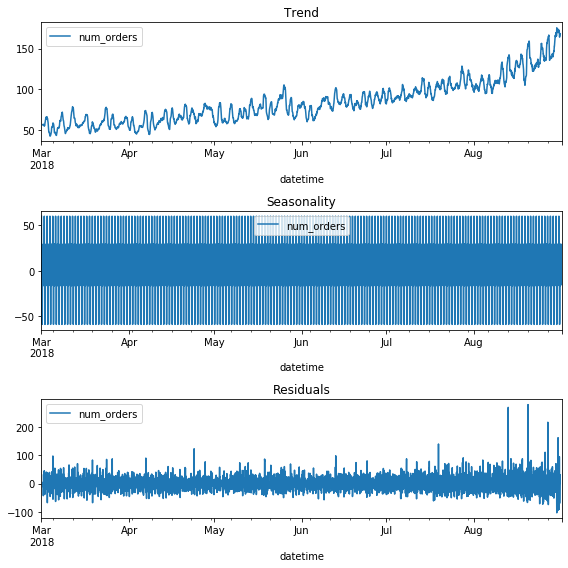

In [109]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout() 

The trend shows a gradual increase with is more visible in the whole data than in the sliced data.

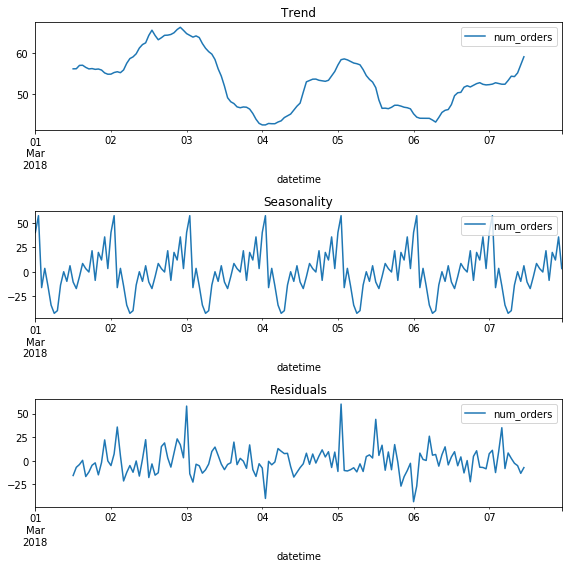

In [110]:
data.sort_index(inplace=True)
data_2 = data['2018-03-01':'2018-03-07']
data_2 = data_2.resample('1H').sum()
decomposed = seasonal_decompose(data_2)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout() 

With a data slice of one week, the seanonality is stationed as it is oscillating within the same points.

## Training

In [111]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
 
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


Generating more features to the dataframe.

In [112]:
make_features(data, 12, 10)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 18 columns):
num_orders      4416 non-null int64
year            4416 non-null int64
month           4416 non-null int64
day             4416 non-null int64
dayofweek       4416 non-null int64
lag_1           4415 non-null float64
lag_2           4414 non-null float64
lag_3           4413 non-null float64
lag_4           4412 non-null float64
lag_5           4411 non-null float64
lag_6           4410 non-null float64
lag_7           4409 non-null float64
lag_8           4408 non-null float64
lag_9           4407 non-null float64
lag_10          4406 non-null float64
lag_11          4405 non-null float64
lag_12          4404 non-null float64
rolling_mean    4406 non-null float64
dtypes: float64(13), int64(5)
memory usage: 815.5 KB


In [113]:
train_and_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_and_valid, shuffle=False, test_size=0.11)

train = train.dropna()

print(len(data))
print(len(train_and_valid))
print(len(train))
print(len(valid))
print(len(test))

4416
3974
3524
438
442


Splitting the dataset train and test as well as displaying the ratio 8.1.1

In [114]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [115]:
features_train, features_temp, target_train, target_temp = train_test_split(features_train, target_train,shuffle=False,train_size=0.9, test_size=0.1,random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp,shuffle=False, test_size=0.1,random_state=12345)

In [116]:
features_train_small, features_valid, target_train_small, target_valid = train_test_split(features_train, target_train, shuffle=False, test_size=0.1)


Declaring the features and targets.

In [118]:
regressor = LinearRegression()
regressor.fit(features_train_small, target_train_small)
 
pred_train_L = regressor.predict(features_train_small)
pred_valid_L = regressor.predict(features_valid)
pred_test_L = regressor.predict(features_test)

rmse_train_L = mean_squared_error(target_train_small, pred_train_L)**0.5
rmse_valid_L = mean_squared_error(target_valid, pred_valid_L)**0.5
rmse_test_L = mean_squared_error(target_test, pred_test_L)**0.5

 
print('MAE for the training set:', mean_absolute_error(target_train_small, pred_train_L))
print('RMSE for the validation set:', rmse_valid_L)
print('RMSE for the test set:', rmse_test_L)

MAE for the training set: 21.461918128359105
RMSE for the validation set: 30.879360133882123
RMSE for the test set: 37.272896982862356


In [119]:
for max_depth in range(1,10,1):
        regressor = DecisionTreeRegressor(max_depth=max_depth, random_state = 42)

        regressor.fit(features_train_small, target_train_small)
        predictions_valid = regressor.predict(features_valid)
        predictions_test = regressor.predict(features_test)
        
        rmse_valid_D = mean_squared_error(target_valid, predictions_valid)**0.5
        rmse_test_D = mean_squared_error(target_test, predictions_test)**0.5
        
        print("Depth =", max_depth, ": rmse_valid =",rmse_valid_D)
        print("Depth =", max_depth, ": rmse_test =",rmse_test_D)

Depth = 1 : rmse_valid = 34.87829863138404
Depth = 1 : rmse_test = 41.84250201118115
Depth = 2 : rmse_valid = 33.39275817296266
Depth = 2 : rmse_test = 40.06994454342683
Depth = 3 : rmse_valid = 33.130539165931815
Depth = 3 : rmse_test = 38.80791851875528
Depth = 4 : rmse_valid = 31.965747132363727
Depth = 4 : rmse_test = 37.63748496834313
Depth = 5 : rmse_valid = 32.2184249722384
Depth = 5 : rmse_test = 35.11856867346339
Depth = 6 : rmse_valid = 33.62976525750816
Depth = 6 : rmse_test = 36.865591113005934
Depth = 7 : rmse_valid = 35.96882137920209
Depth = 7 : rmse_test = 42.4554234895078
Depth = 8 : rmse_valid = 36.317628409991286
Depth = 8 : rmse_test = 45.09002750480944
Depth = 9 : rmse_valid = 37.73199354878646
Depth = 9 : rmse_test = 42.10018048487074


In [120]:

for estim in range(5,16,5):
    for depth in range(1,10,1):
        for leaf in range(1,5):

                    regressor = RandomForestRegressor(n_estimators=estim,max_depth=depth, random_state=54321, min_samples_leaf=leaf)

                    predictions = pd.Series(target_test.mean(), index=target_test.index)
                    mse = mean_squared_error(target_test, predictions)

                    regressor.fit(features_train_small, target_train_small)
                    predictions_train = regressor.predict(features_train_small)
                    predictions_test = regressor.predict(features_test)
                    predictions_valid = regressor.predict(features_valid)

                    rmse_R = mean_squared_error(target_valid, predictions_valid)**0.5
                
                    print("n_estimators =", estim, " :max_depth =",depth, " ,:min_samples_leaf=",leaf, ":rmse =", rmse_R) 


n_estimators = 5  :max_depth = 1  ,:min_samples_leaf= 1 :rmse = 35.67807753929451
n_estimators = 5  :max_depth = 1  ,:min_samples_leaf= 2 :rmse = 35.67807753929451
n_estimators = 5  :max_depth = 1  ,:min_samples_leaf= 3 :rmse = 35.67807753929451
n_estimators = 5  :max_depth = 1  ,:min_samples_leaf= 4 :rmse = 35.67807753929451
n_estimators = 5  :max_depth = 2  ,:min_samples_leaf= 1 :rmse = 33.35554849912337
n_estimators = 5  :max_depth = 2  ,:min_samples_leaf= 2 :rmse = 33.35554849912337
n_estimators = 5  :max_depth = 2  ,:min_samples_leaf= 3 :rmse = 33.35554849912337
n_estimators = 5  :max_depth = 2  ,:min_samples_leaf= 4 :rmse = 33.35554849912337
n_estimators = 5  :max_depth = 3  ,:min_samples_leaf= 1 :rmse = 32.44874471515147
n_estimators = 5  :max_depth = 3  ,:min_samples_leaf= 2 :rmse = 32.44874471515147
n_estimators = 5  :max_depth = 3  ,:min_samples_leaf= 3 :rmse = 32.44874471515147
n_estimators = 5  :max_depth = 3  ,:min_samples_leaf= 4 :rmse = 32.44874471515147
n_estimators = 5

## Testing

Selecting the best model

In [121]:
final_model = LinearRegression()
regressor.fit(features_train_small, target_train_small)
 
pred_train_L = regressor.predict(features_train_small)
pred_valid_L = regressor.predict(features_valid)
pred_test_L = regressor.predict(features_test)

rmse_train_L = mean_squared_error(target_train_small, pred_train_L)**0.5
rmse_valid_L = mean_squared_error(target_valid, pred_valid_L)**0.5
rmse_test_L = mean_squared_error(target_test, pred_test_L)**0.5

print('RMSE for the training set:', rmse_train_L)
print('RMSE for the validation set:', rmse_valid_L)
print('RMSE for the testing set:', rmse_test_L)
print( )
print('MAE for the test set:', mean_absolute_error(target_test, pred_test_L))

RMSE for the training set: 19.660659959535963
RMSE for the validation set: 29.0105018492471
RMSE for the testing set: 34.050114786856454

MAE for the test set: 26.571737105966623


Linear Regression is the best model to train this dataset as it gives an RMSE of 37 with the test dataset, which is below 48 as required.